# Project 3 - Reddit classifier

## Part B) Using NLP to make ML classification models

### Problem statement: 
##### Developing a subreddit classifier for `tea` and `Coffee` posts using various ML classification models to identify the best combination of hyperparameters using Gridsearch and Pipelines. 

### Executive summary:
##### Extracted data from the `tea` and `Coffee` subreddits using API wrapper PRAW, as outlined by Reddit. A maximum of 1000 posts maybe obtained using API requests, and for the subreddits modeled in this projects, two data sets of approximately 1000 posts were obtained. From the Reddit data sets for the two subreddits, data was cleaned, explored, and analysed before using them to develop ML classification models. Also, the data was analysed for any correlations or interesting patterns.

### Contents

- [Data extraction using PRAW in `RedditAPI_and_data_acquisition.ipynb`](#)
- [Exploratory Data Analysis and data visualization](#Exploratory-Data-Analysis)
- [Baseline accuracy](#Baseline-accuracy)
- [Model Development: Different classification models](#Developin-the-statistical-and-machine-learning-models)
- [Looking at subreddit vector alignment](#Attempt-at-creating-vectors-and-testing-for-alignment)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

In [1]:
# Import libraries
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar


%matplotlib inline

In [2]:
# Increasing rows and columns displayed
pd.options.display.max_rows = 2000
pd.options.display.max_columns = 5000

In [3]:
# Reading the subreddit csv
tea_data = pd.read_csv('./../data/tea_data.csv')
coffee_data = pd.read_csv('./../data/coffee_data.csv')

In [4]:
# Add a column to identify the dataframe rows
tea_data['subreddit'] = 'tea'
coffee_data['subreddit'] = 'coffee'

In [5]:
# Combine the two subreddit dataframes into a new one called beverage
beverage = tea_data.append(coffee_data)
beverage.reset_index(drop=True, inplace=True)

beverage.shape

(1982, 9)

## Exploratory Data Analysis and Data Visualization

In [6]:
# Checking for nan in the beverage dataframe
beverage.isna().mean()

title        0.000000
id           0.000000
over_18      0.000000
is_self      0.000000
selftext     0.809284
score        0.000000
rank         0.000000
created      0.000000
subreddit    0.000000
dtype: float64

#### Most of the posts do not contain any text outside titles. The fraction of empty posts are higher in `tea `

In [7]:
# Adding columns of date of posting
beverage['created'] = beverage['created'].apply(lambda x: pd.to_datetime(x), 'columns')

# Adding time and hour of posting
beverage['month'] = beverage['created'].apply(lambda x: x.month)
beverage['hour'] = beverage['created'].apply(lambda x: x.hour)

# Chaning the subreddit id to numerical categories. 0: Tea and 1: Coffee
beverage['subreddit'] = beverage['subreddit'].replace({'tea':0, 'coffee':1})

In [8]:
# Dropping the columns and datatypes, that are of little importance
beverage.drop(['selftext','is_self','over_18','id','created','rank','id'], axis=1, inplace=True)

In [9]:
# Creating row with lenth of titles
beverage['characters'] = beverage.loc[:,'title'].map(lambda x: len(x))
beverage.head()

,title,score,subreddit,month,hour,characters
0,Perfect job doesn't exi-,8271,0,2,3,24
1,One thing coffee and tea drinkers can agree on...,7908,0,10,2,75
2,4chan's Beginners Guide on Tea,5975,0,4,5,30
3,My buddies like the warmth,4339,0,3,2,26
4,There's no better way to do it. [x-post /r/iran],4317,0,12,5,48


//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


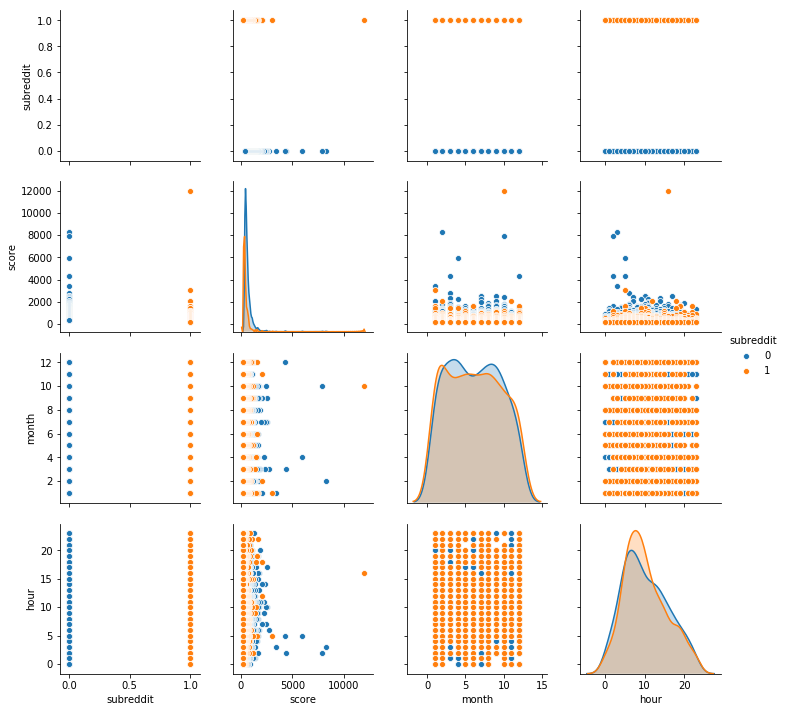

In [10]:
# Correlations between features
sns.pairplot(beverage[['subreddit','score','month','hour']], hue='subreddit');

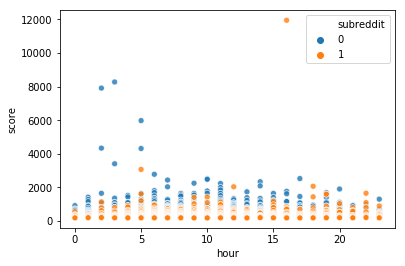

In [11]:
# Scatter plot of score against time
sns.scatterplot(beverage['hour'],beverage['score'],hue=beverage['subreddit'], alpha=0.8);

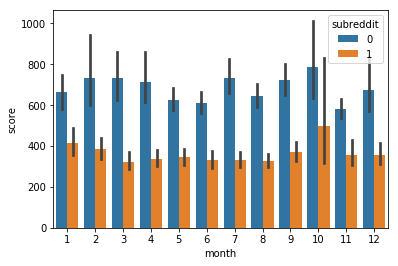

In [12]:
# Barplot comparison of upvotes against month
sns.barplot('month','score','subreddit',beverage);

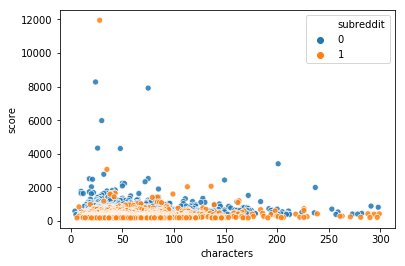

In [13]:
# Scatterplot of upvotes based on length of title
sns.scatterplot(beverage['characters'], beverage['score'], hue=beverage['subreddit'], alpha = 0.85);

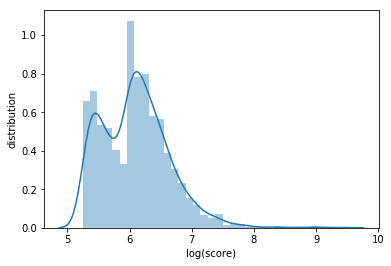

In [14]:
# Looking at distribution of scores on log scale

# sns.distplot((beverage['score']),kde=True)
sns.distplot(np.log(beverage['score']),kde=True)
plt.xlabel('log(score)')
plt.ylabel('distribution');

# Baseline accuracy

In [15]:
beverage['subreddit'].value_counts(normalize=True)

0    0.504036
1    0.495964
Name: subreddit, dtype: float64

Our baseline accuracy is 50.4%, if were to randomly assign every post to be from subreddit `tea`, we would be around 50 times correct out of 100. Our classes seem very well balanced.

# Developing the statistical and machine learning models

In [16]:
# Will be fitting the title words to the subreddit category
X = beverage['title']
y = beverage['subreddit']

In [17]:
# Import model and machine learning algorithm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import BernoulliNB

In [18]:
# Train-test split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)

### Gridsearch and Pipeline

##### Model 1: TfidfVectorizer + Logistic Regression 

In [19]:
# Model 1: TfidfVectprizer + Logisitc Regression
pipe1 = Pipeline([
    ('tvec',TfidfVectorizer()),
    ('lr',LogisticRegression(penalty = 'l1', solver='liblinear', random_state = 42))
])

pipe1_params = {
    'tvec__max_features':[75],
    'tvec__lowercase':[True],
    'tvec__stop_words':['english'],
    'tvec__ngram_range':[(1, 1)],
}

In [20]:
# Gridsearch to check for optimum hyperparamters
gs1 = GridSearchCV(pipe1,
                  pipe1_params,
                  cv=3,
                  return_train_score=True) 

In [21]:
# Model fit
gs1.fit(X_train, y_train);
# gs1.cv_results_

In [22]:
gs1.best_params_

{'tvec__lowercase': True,
 'tvec__max_features': 75,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [23]:
gs1.score(X_train, y_train)

0.8764129615674454

In [24]:
gs1.score(X_test, y_test)

0.8488549618320611

##### Model 2: TfidfVectorizer + Bernoulli Naive Bayes

In [26]:
# Model 2: TfidfVectorizer + Bernoulli Naive Bayes
pipe2 = Pipeline([
    ('cvec',CountVectorizer()),
    ('bnb', BernoulliNB(binarize=0.50))
])

pipe2_params = {
    'cvec__max_features':[75],
    'cvec__lowercase':[True],
    'cvec__stop_words':['english'],
    'cvec__ngram_range':[(1, 1)],
}

In [27]:
gs2 = GridSearchCV(pipe2,
                   pipe2_params,
                   cv=3,
                   return_train_score=True)

gs2.fit(X_train, y_train)
# gs2.cv_results_

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [28]:
gs2.best_params_

{'cvec__lowercase': True,
 'cvec__max_features': 75,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [29]:
gs2.score(X_train, y_train)

0.86586284853052

In [30]:
gs2.score(X_test, y_test)

0.850381679389313

##### Model 3: CountVectorizer + Logistic Regression

In [31]:
pipe3 = Pipeline([
    ('cvec',CountVectorizer()),
    ('lr',LogisticRegression(penalty = 'l1', solver='liblinear', random_state = 42))
])

pipe3_params = {
    'cvec__max_features':[75],
    'cvec__lowercase':[True],
    'cvec__stop_words':['english'],
    'cvec__ngram_range':[(1, 1)],
}

gs3 = GridSearchCV(pipe3,
                  pipe3_params,
                  cv=3,
                  return_train_score=True) 

gs3.fit(X_train, y_train);
# gs3.cv_results_

In [32]:
gs3.best_params_

{'cvec__lowercase': True,
 'cvec__max_features': 75,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [33]:
gs3.score(X_train, y_train)

0.8786737000753579

In [34]:
gs3.score(X_test, y_test)

0.8519083969465648

##### Model 4: TfidfVectorizer + KNearest Neighbors

In [35]:
# Import knn model and stadarize scaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [36]:
pipe4 = Pipeline([
    ('tvec',TfidfVectorizer()),
    ('knn',KNeighborsClassifier())
])

pipe4_params = {
    'tvec__max_features':[75],
    'tvec__lowercase':[True],
    'tvec__stop_words':['english'],
    'tvec__ngram_range':[(1, 1)],
    'knn__n_neighbors':[5]
}

gs4 = GridSearchCV(pipe4,
                  pipe4_params,
                  cv=3,
                  return_train_score=True) 

gs4.fit(X_train, y_train);
# gs4.cv_results_

In [37]:
gs4.best_params_

{'knn__n_neighbors': 5,
 'tvec__lowercase': True,
 'tvec__max_features': 75,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [38]:
gs4.score(X_train, y_train)

0.8515448379804069

In [39]:
gs4.score(X_test, y_test)

0.7938931297709924

##### Model 5: Descision Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

In [41]:
pipe5 = Pipeline([
    ('tvec',TfidfVectorizer()),
    ('tree',DecisionTreeClassifier(random_state = 42))
])

pipe5_params = {
    'tvec__max_features':[75],
    'tvec__lowercase':[True],
    'tvec__stop_words':['english'],
    'tvec__ngram_range':[(1, 1)],
    'tree__max_depth':[15],
    'tree__min_samples_split':[2],
    'tree__min_samples_leaf':[7]
}

gs5 = GridSearchCV(pipe5,
                  pipe5_params,
                  cv=3,
                  return_train_score=True) 

gs5.fit(X_train, y_train);
gs5.cv_results_

{'mean_fit_time': array([0.0265077]),
 'std_fit_time': array([0.00286284]),
 'mean_score_time': array([0.00787886]),
 'std_score_time': array([0.00063661]),
 'param_tree__max_depth': masked_array(data=[15],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_tree__min_samples_leaf': masked_array(data=[7],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_tree__min_samples_split': masked_array(data=[2],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_tvec__lowercase': masked_array(data=[True],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_tvec__max_features': masked_array(data=[75],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_tvec__ngram_range': masked_array(data=[(1, 1)],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_tvec__stop_words': masked_array

In [42]:
gs5.best_params_

{'tree__max_depth': 15,
 'tree__min_samples_leaf': 7,
 'tree__min_samples_split': 2,
 'tvec__lowercase': True,
 'tvec__max_features': 75,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [43]:
gs5.score(X_train, y_train)

0.8409947249434815

In [44]:
gs5.score(X_test, y_test)

0.8534351145038168

##### Model 6: ExtraTreeClassifier

In [45]:
pipe6 = Pipeline([
    ('tvec',TfidfVectorizer()),
    ('extra_tree',ExtraTreeClassifier(random_state = 42))
])

pipe6_params = {
    'tvec__max_features':[75, 100, 500],
    'tvec__lowercase':[True],
    'tvec__stop_words':['english'],
    'tvec__ngram_range':[(1, 1)],
    'extra_tree__max_depth':[16],
    'extra_tree__min_samples_split':[500],
    'extra_tree__min_samples_leaf':[4]
}

gs6 = GridSearchCV(pipe6,
                  pipe6_params,
                  cv=3,
                  return_train_score=True) 

gs6.fit(X_train, y_train);
# gs6.cv_results_;

In [46]:
gs6.best_params_

{'extra_tree__max_depth': 16,
 'extra_tree__min_samples_leaf': 4,
 'extra_tree__min_samples_split': 500,
 'tvec__lowercase': True,
 'tvec__max_features': 100,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [47]:
gs6.score(X_train, y_train)

0.8214016578749058

In [48]:
gs6.score(X_test, y_test)

0.8274809160305343

NOTE: ExtraTreeClassifier is showing more similar test and train scores. The model is more robust!

##### Model 7: DecisionTreeClassifier with bagging

In [49]:
from sklearn.ensemble import BaggingClassifier
# Can I add a bagging classifier into a gridsearch or pipeline?

In [50]:
pipe7 = Pipeline([
    ('tvec',TfidfVectorizer()), 
    ('bag',BaggingClassifier())
])

pipe7_params = {
    'tvec__max_features':[75],
    'tvec__lowercase':[True],
    'tvec__stop_words':['english'],
    'tvec__ngram_range':[(1, 1)],
    'bag__base_estimator':[DecisionTreeClassifier(max_depth = 20,min_samples_leaf= 10,min_samples_split= 2, random_state=42)],
    'bag__n_estimators':[10],
}

gs7 = GridSearchCV(
    pipe7,
    pipe7_params,
    cv = 3,
    return_train_score=True
)

gs7.fit(X_train, y_train)

gs7.cv_results_

{'mean_fit_time': array([0.04842083]),
 'std_fit_time': array([0.00350347]),
 'mean_score_time': array([0.01533588]),
 'std_score_time': array([0.00267594]),
 'param_bag__base_estimator': masked_array(data=[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=10, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=42, splitter='best')],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_bag__n_estimators': masked_array(data=[10],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_tvec__lowercase': masked_array(data=[True],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_tvec__max_features': masked_arra

In [51]:
gs7.best_params_

{'bag__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=10, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=42, splitter='best'),
 'bag__n_estimators': 10,
 'tvec__lowercase': True,
 'tvec__max_features': 75,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [52]:
gs7.score(X_train, y_train)

0.8470233609645818

In [53]:
gs7.score(X_test, y_test)

0.8488549618320611

##### Model 8: Random forest

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
pipe8 = Pipeline([
    ('tvec',TfidfVectorizer()), 
    ('rf',RandomForestClassifier(random_state=42))
])

pipe8_params = {
    'tvec__max_features':[75],
    'tvec__lowercase':[True],
    'tvec__stop_words':['english'],
    'tvec__ngram_range':[(1, 1)],
    'rf__n_estimators':[10],
    'rf__min_samples_leaf':[5]
}

gs8 = GridSearchCV(pipe8,
                   pipe8_params,
                   cv = 5,
                   n_jobs=-1,
                   return_train_score=True)

gs8.fit(X_train, y_train);

# gs8.cv_results_

In [56]:
gs8.best_params_

{'rf__min_samples_leaf': 5,
 'rf__n_estimators': 10,
 'tvec__lowercase': True,
 'tvec__max_features': 75,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [57]:
gs8.best_score_

0.8492840994724944

In [58]:
gs8.score(X_train, y_train)

0.8741522230595328

In [59]:
gs8.score(X_test, y_test)

0.8396946564885496

# Attempt at creating vectors and testing for alignment

## 1) With adding vectors on separate sets

## 2) With basis or eigen vectors (Not completed in this project, needs more work to be done)

In [60]:
# 1) With adding vectors on separate sets
# Creating new variable with only titles from `tea` and `coffee` separately
tea_titles = beverage[beverage['subreddit']==0]['title']
coffee_titles = beverage[beverage['subreddit']==1]['title']

coffee_titles.reset_index(drop = True, inplace=True)
max_features_chosen =1000

In [61]:
# Using a CountVectorizer to tranform the tea titles.
# Note this same transformation will be applied on coffee
cvec = CountVectorizer(lowercase=True, max_df=0.9, stop_words='english', max_features=max_features_chosen)

##### A) Fitting coffee to tea subreddit vector!

In [62]:
# Fitting the CountVectorizer on tea titles
cvec.fit(tea_titles)
names = cvec.get_feature_names()
# print(names)
tea_titles = cvec.transform(tea_titles)

In [63]:
# Converting to array from sparse matrix
tea_titles = tea_titles.toarray()

# Adding all the vectors in tea CountVectorizer to obtain a vector representative of tea
tea_sum = np.sum(tea_titles, axis=0)

# Normalizing of the net vector for subreddit 'tea'
sum=0
tea_vec = []
for i in tea_sum.T:
    tea_vec.append(i)
    sum += i**2
tea_vec = np.array(tea_vec)
tea_vec = tea_vec / np.sqrt(sum)

# tea_vec

In [64]:
# Tranforming the coffee titles according to the transformation for tea title
# This should create a vector with same components (or words) as that in tea titles
coffee_titles = cvec.transform(coffee_titles)

In [65]:
# Converting coffee titles to array from sparse matrix
coffee_titles = coffee_titles.toarray()

# Adding all the vectors in coffee CountVectorizer to obtain a vector representative of coffee 
# (using components of tea)
coffee_sum = np.sum(coffee_titles, axis=0)

# Normalizing of the net vector for subreddit 'coffee'
sum=0
coffee_vec = []
for i in coffee_sum.T:
    coffee_vec.append(i)
    sum += i**2

coffee_vec = np.array(coffee_vec)

coffee_vec = coffee_vec / np.sqrt(sum)

# coffee_vec

In [66]:
# Looking at the dot product of `tea` and `coffee` subreddit vectors
# this should provide an idea of how separated they are
np.dot(coffee_vec, tea_vec)

0.10408647998153123

In [67]:
np.arccos(np.dot(coffee_vec, tea_vec))*180/np.pi

84.0254626735217

In [68]:
df_dict = {'names':names, 'tea_vector':tea_vec, 'coffee_vector':coffee_vec}

In [69]:
df1 = pd.DataFrame(df_dict)
df1.head()

,names,tea_vector,coffee_vector
0,10,0.005595,0.009713
1,100,0.006993,0.004856
2,14,0.002797,0.001619
3,20,0.004196,0.003238
4,2017,0.002797,0.000000


In [70]:
df1[df1['coffee_vector'] == 0.0]

,names,tea_vector,coffee_vector
4,2017,0.002797,0.0
6,300,0.002797,0.0
15,adorable,0.005595,0.0
16,advent,0.005595,0.0
17,afford,0.004196,0.0
18,afternoon,0.019581,0.0
20,ain,0.004196,0.0
21,airport,0.005595,0.0
23,alishan,0.002797,0.0
28,apple,0.002797,0.0


In [71]:
df1[df1['coffee_vector'] != 0.0]

,names,tea_vector,coffee_vector
0,10,0.005595,0.009713
1,100,0.006993,0.004856
2,14,0.002797,0.001619
3,20,0.004196,0.003238
5,24,0.004196,0.006475
7,50,0.002797,0.012950
8,500,0.002797,0.003238
9,able,0.004196,0.003238
10,absolutely,0.008392,0.001619
11,actual,0.004196,0.003238


##### B) Fitting tea to coffee subreddit vector

In [72]:
# 1) With adding vectors on separate sets
# Creating new variable with only titles from `tea` and `coffee` separately
tea_titles = beverage[beverage['subreddit']==0]['title']
coffee_titles = beverage[beverage['subreddit']==1]['title']

coffee_titles.reset_index(drop = True, inplace=True)

In [73]:
# Using a CountVectorizer to tranform the coffee titles.
# Note this same transformation will be applied on tea
cvec2 = CountVectorizer(lowercase=True, max_df=0.9, stop_words='english', max_features = max_features_chosen)

In [74]:
# Fitting the CountVectorizer on tea titles
cvec2.fit(coffee_titles)
names = cvec2.get_feature_names()
# print(names)
coffee_titles = cvec2.transform(coffee_titles)

In [75]:
# Converting to array from sparse matrix
coffee_titles = coffee_titles.toarray()

# Adding all the vectors in tea CountVectorizer to obtain a vector representative of coffee
coffee_sum = np.sum(coffee_titles, axis=0)

# Normalizing of the net vector for subreddit 'coffee'
sum=0
coffee_vec = []
for i in coffee_sum.T:
    coffee_vec.append(i)
    sum += i**2
coffee_vec = np.array(coffee_vec)
coffee_vec = coffee_vec / np.sqrt(sum)

# coffee_vec

In [76]:
# Tranforming the tea titles according to the transformation for coffee title
# This should create a vector with same components (or words) as that in coffee titles
tea_titles = cvec2.transform(tea_titles)

In [77]:
# Converting tea titles to array from sparse matrix
tea_titles = tea_titles.toarray()

# Adding all the vectors in coffee CountVectorizer to obtain a vector representative of coffee 
# (using components of tea)
tea_sum = np.sum(tea_titles, axis=0)

# Normalizing of the net vector for subreddit 'coffee'
sum=0
tea_vec = []
for i in tea_sum.T:
    tea_vec.append(i)
    sum += i**2

tea_vec = np.array(tea_vec)

tea_vec = tea_vec / np.sqrt(sum)

# tea_vec

In [78]:
# Looking at the dot product of `tea` and `coffee` subreddit vectors
# this should provide an idea of how separated they are
np.dot(coffee_vec, tea_vec)

0.10370616100092632

In [79]:
np.arccos(np.dot(coffee_vec, tea_vec))*180/np.pi

84.04737191601953

In [80]:
df_dict = {'names':names, 'tea_vector':tea_vec, 'coffee_vector':coffee_vec}

In [81]:
df2 = pd.DataFrame(df_dict)
df2.head()

,names,tea_vector,coffee_vector
0,000,0.001418,0.007927
1,10,0.005670,0.009513
2,100,0.007088,0.004756
3,12,0.001418,0.009513
4,15,0.000000,0.003171


In [82]:
df2[df2['tea_vector'] == 0.0]

,names,tea_vector,coffee_vector
4,15,0.0,0.003171
5,150,0.0,0.003171
7,1893,0.0,0.003171
9,200,0.0,0.003171
10,2014,0.0,0.003171
11,2016,0.0,0.011098
12,23,0.0,0.003171
15,2nd,0.0,0.003171
17,35,0.0,0.004756
19,49,0.0,0.003171


In [83]:
df2[df2['tea_vector'] != 0.0]

,names,tea_vector,coffee_vector
0,000,0.001418,0.007927
1,10,0.005670,0.009513
2,100,0.007088,0.004756
3,12,0.001418,0.009513
6,16,0.001418,0.009513
8,20,0.004253,0.003171
13,24,0.004253,0.006342
14,25,0.001418,0.003171
16,30,0.001418,0.007927
18,3d,0.001418,0.004756


In [84]:
# Set of common words that matter in our model
common_words = set(df2['names']).intersection(df1['names'])

In [85]:
# Number of such common words
len(common_words)

385

In [86]:
# Set of those common words
common_words

{'10',
 '100',
 '20',
 '24',
 '50',
 '500',
 'able',
 'actual',
 'actually',
 'add',
 'ago',
 'album',
 'amazing',
 'antique',
 'appreciate',
 'art',
 'asked',
 'attempt',
 'aunt',
 'away',
 'awesome',
 'baby',
 'bad',
 'bag',
 'bar',
 'bean',
 'beautiful',
 'beer',
 'best',
 'better',
 'big',
 'birthday',
 'bit',
 'black',
 'blown',
 'blue',
 'boss',
 'boston',
 'bought',
 'box',
 'brew',
 'brewed',
 'brewing',
 'broke',
 'brought',
 'built',
 'buy',
 'buying',
 'came',
 'cat',
 'cheap',
 'chicago',
 'chocolate',
 'christmas',
 'city',
 'class',
 'close',
 'coffee',
 'cold',
 'college',
 'come',
 'comments',
 'community',
 'cool',
 'country',
 'coworker',
 'cream',
 'culture',
 'cup',
 'cups',
 'dad',
 'daily',
 'dark',
 'day',
 'days',
 'decided',
 'delicious',
 'designed',
 'did',
 'didn',
 'different',
 'does',
 'doesn',
 'doing',
 'don',
 'dragon',
 'drink',
 'drinkers',
 'drinking',
 'drinks',
 'effect',
 'enjoy',
 'exactly',
 'excited',
 'experience',
 'family',
 'fan',
 'fancy'

## Conclusion and Recommendations

For the data obtained and analyzed, the following inferences and conclusions were made:

* Contrary to initial expectations, there is little to no correlation of upvotes and posts to creation time
* There is dedicated coffee and tea members posting in their respective subreddits
* There are both common and unique words to each subreddit. The unique words are often names of different kinds of the beverage that subreddit is referring to or names of places they are grown in
* Various models were fitted and their scores were compared. The tree classifiers tend to offer higher accuracy while being robust
* Logistic Regression models seemed to perform on the same level of accuracy as tree models
* Models showed significant improvement of accuracy scores from baseline of 50% to more than 85% using classification models
* A vector space model was attempted at to obtain basis vectors for each subreddit in a rather crude fashion but showed significant separation of vectors, showing close to orthogonality of the two subreddit spaces

The objective of project was to compare various classification models and towards that various kinds of models were fit and compared while optimizing the hyperparamters. Also, a rudimentary vector space analysis was done and shown to have significance as a possible classifier.